# **Step 1 : Libraries & Datasets**

In [6]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing and modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Loading the dataset
df = pd.read_csv('/content/creditcard.csv')

# **Step 2 : Basic Exploration**

In [7]:
# First 5 rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Dataset shape
print(f"Dataset Shape:\n{df.shape}")

# Column Info
print(f"Column Info:\n{df.info}")

Dataset Shape:
(284807, 31)
Column Info:
<bound method DataFrame.info of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21 

In [9]:
# Class distribution (fraud vs non-fraud), Where 1 is the number of fraud Transactions
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [10]:
# Check for missing values
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


# **Step 3: Exploratory Data Analysis (EDA)**

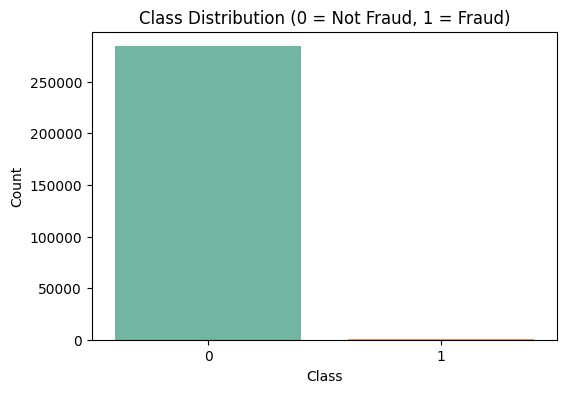

Fraud Cases: 492 | Non-Fraud Cases: 284315
Percentage of Fraud: 0.1727%


In [11]:
# 1. Class Distribution (Fraud vs Non-Fraud)

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class', palette='Set2')
plt.title("Class Distribution (0 = Not Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

fraud_count = df['Class'].value_counts()[1]
nonfraud_count = df['Class'].value_counts()[0]
print(f"Fraud Cases: {fraud_count} | Non-Fraud Cases: {nonfraud_count}")
print(f"Percentage of Fraud: {round((fraud_count/len(df))*100, 4)}%")

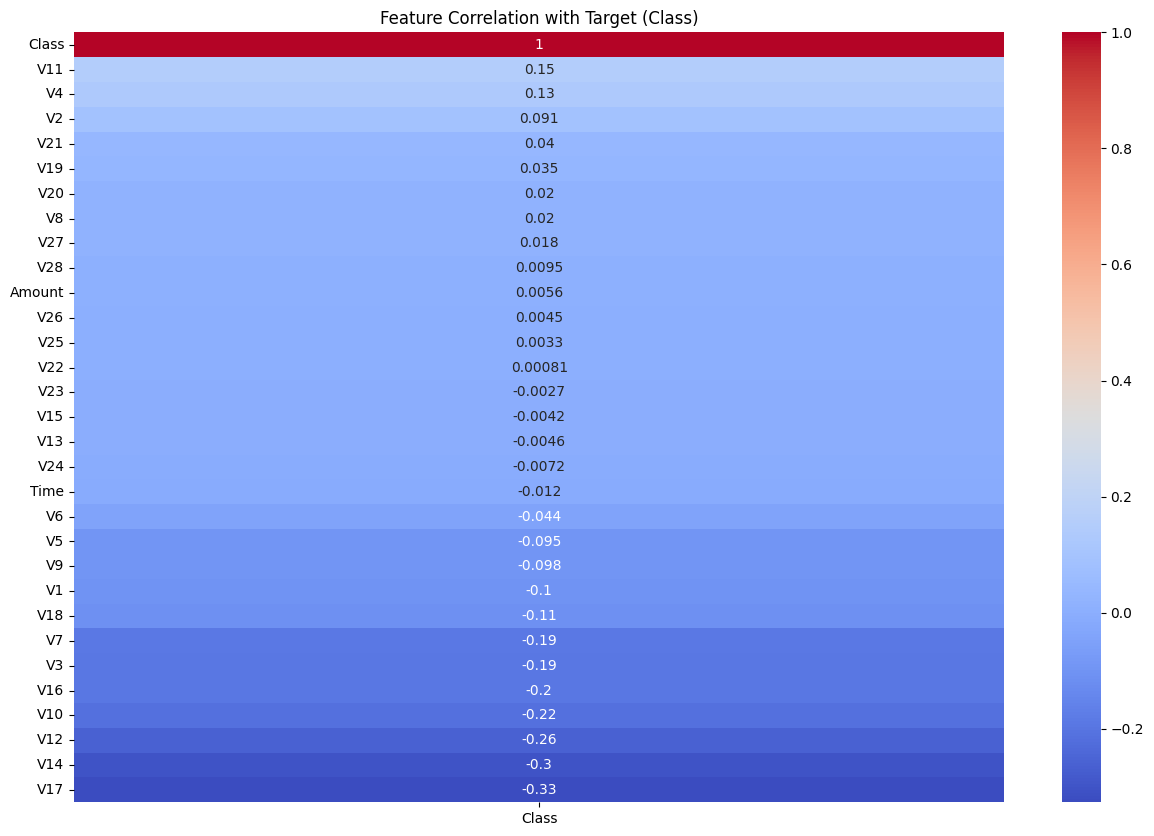

In [12]:
# 2. Correlation Heatmap (Feature Correlation with Fraud)

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target (Class)")
plt.show()

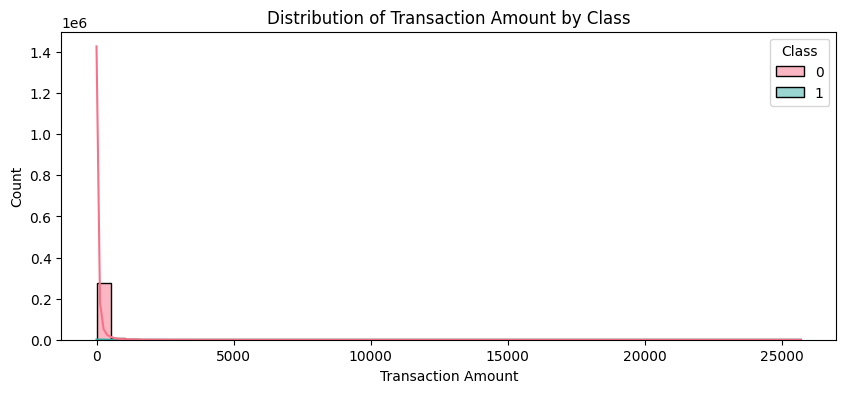

In [13]:
# 3. Distribution of Transaction Amount by Class

plt.figure(figsize=(10,4))
sns.histplot(data=df, x='Amount', hue='Class', bins=50, kde=True, palette='husl')
plt.title("Distribution of Transaction Amount by Class")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.show()

# **Step 4: Data Preprocessing**

In [14]:
# 1. Droping Time Column as currently we dont need it cause we are not using time series here
df = df.drop(columns=['Time'])

In [15]:
# 2. Feature Scaling (I scaled the Amount column since it's not PCA-transformed like other columns (V1 to V28).)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [16]:
# 3. Split the Data

from sklearn.model_selection import train_test_split

X = df.drop(columns = ["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify = y)

In [17]:
# 4. Handle Imbalance with SMOTE (Synthetic Minority Oversampling Technique), Since fraud data is highely imbalance as we saw in the distribution so well balance them using SMOTE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

# Check balance
print(f"Before SMOTE: {X_train.value_counts()}")
print(f"After SMOTE: {X_train_sm.value_counts()}")

Before SMOTE: V1         V2         V3         V4         V5         V6         V7         V8         V9         V10        V11        V12        V13        V14        V15        V16        V17        V18        V19        V20        V21        V22        V23        V24        V25        V26        V27        V28        Amount   
 2.055797  -0.326668  -2.752041  -0.842316   2.463072   3.173856  -0.432126   0.727706   0.608606  -0.075186   0.063504   0.350564  -0.141238   0.690972   1.275257  -0.371962  -0.601957  -0.052640  -0.330590  -0.180370   0.269765   0.844627   0.020675   0.726212   0.366624  -0.398828   0.027735  -0.060282  -0.349231    63
 1.245674   0.166975   0.488306   0.635322  -0.562777  -1.011073   0.014953  -0.160211   0.170362  -0.044575  -0.356749  -0.073460  -0.517760   0.406969   1.124147   0.342470  -0.374656  -0.438992  -0.116091  -0.132080  -0.262581  -0.816264   0.140304   0.357827   0.186423   0.096544  -0.035866   0.018495  -0.317287    62
 2.053311   0.089735

# **Step 5: Model Building and Evaluation**

In [27]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

log_model = LogisticRegression(max_iter = 1000, random_state = 42)
log_model.fit(X_train_sm, y_train_sm)

y_pred_log = log_model.predict(X_test)

# Evaluation
print(f"Logistic Regression Evaluation :")
print(f"\nAccuracy score: {accuracy_score(y_test, y_pred_log)}")
print(f"\nClassification Report:\n{y_test, y_pred_log}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_log)}")

Logistic Regression Evaluation :

Accuracy score: 0.9733682103858713

Classification Report:
(263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))

Confusion Matrix:
[[55355  1509]
 [    8    90]]


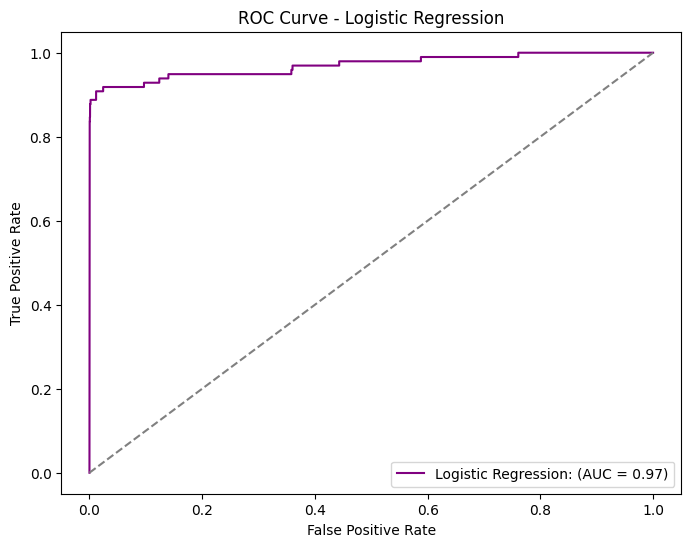

In [37]:
# ROC Curve for Logistic Regression

from sklearn.metrics import roc_curve, auc

# probalilities
y_prob_log = log_model.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

# Plotting ROC Curve

plt.figure(figsize = (8,6))
plt.plot(fpr_log, tpr_log, color = "purple", label = f"Logistic Regression: (AUC = {roc_auc_log:.2f})")
plt.plot([0,1],[0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In [28]:
# 2. Desicion Tree

from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state = 42, max_depth = 5)
tree_model.fit(X_train_sm, y_train_sm)

y_pred_tree = tree_model.predict(X_test)

print(f"Evaluation Matrics:")
print(f"\nDecision Tree Accuracy score: {accuracy_score(y_test, y_pred_tree)}")
print(f"\nDecision Tree Classification Report:\n{y_test, y_pred_tree}")
print(f"\nDecision Tree Confusion Matrix:\n{confusion_matrix(y_test, y_pred_tree)}")

Evaluation Matrics:

Decision Tree Accuracy score: 0.9661177627190056

Decision Tree Classification Report:
(263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))

Decision Tree Confusion Matrix:
[[54944  1920]
 [   10    88]]


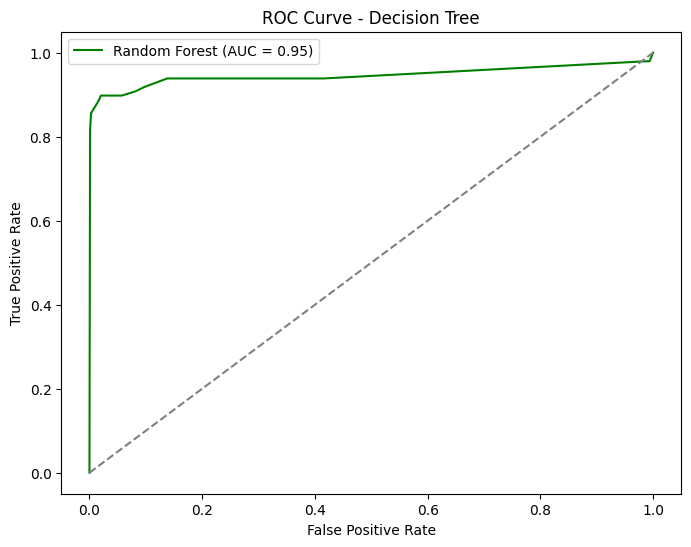

In [36]:
# Ploting ROC Curve & AUC Score

from sklearn.metrics import roc_curve, auc

# Probabilities
y_prob_dt = tree_model.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, color="green", label=f"Random Forest (AUC = {roc_auc_dt:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()

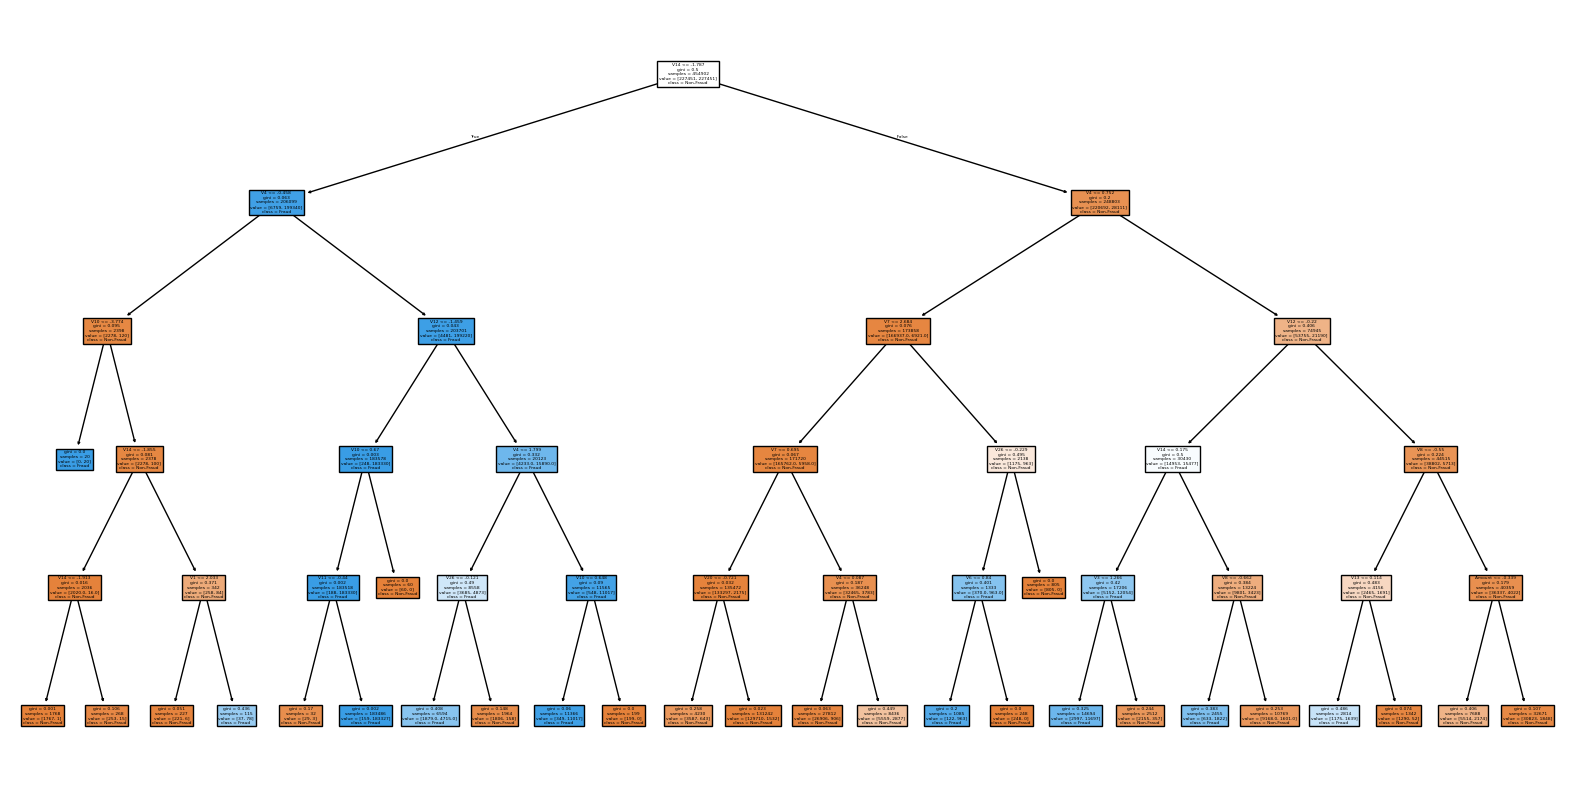

In [29]:
# Visualizing the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=["Non-Fraud", "Fraud"])
plt.show()

In [30]:
# 3. Random Forest CLassifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators= 100, random_state = 42)
rf_model.fit(X_train_sm, y_train_sm)

y_pred_rf = rf_model.predict(X_test)

print(f"Evaluation Matrics for Random Forest:")
print(f"\nRandom Forest Accuracy score: {accuracy_score(y_test, y_pred_rf)}")
print(f"\nRandom Forest Classification Report:\n{y_test, y_pred_rf}")
print(f"\nRandom Forest Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")

Evaluation Matrics for Random Forest:

Random Forest Accuracy score: 0.9994908886626171

Random Forest Classification Report:
(263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))

Random Forest Confusion Matrix:
[[56852    12]
 [   17    81]]


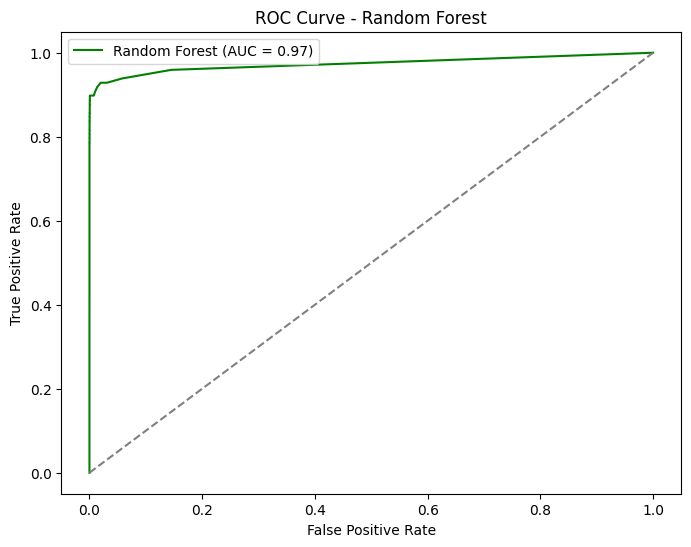

In [35]:
# Ploting ROC Curve & AUC Score

from sklearn.metrics import roc_curve, auc

# Probabilities
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color="green", label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

In [32]:
# 4. XGBoost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = "logloss", random_state = 42)
xgb_model.fit(X_train_sm, y_train_sm)

y_pred_xgb = xgb_model.predict(X_test)

print(f"Evaluation Matrics for XGBoost:")
print(f"\nXGBoost Accuracy score: {accuracy_score(y_test, y_pred_xgb)}")
print(f"\nXGBoost Classification Report:\n{y_test, y_pred_xgb}")
print(f"\nXGBoost Confusion Matrix:\n{confusion_matrix(y_test, y_pred_xgb)}")

Evaluation Matrics for XGBoost:

XGBoost Accuracy score: 0.9990871107053826

XGBoost Classification Report:
(263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))

XGBoost Confusion Matrix:
[[56825    39]
 [   13    85]]


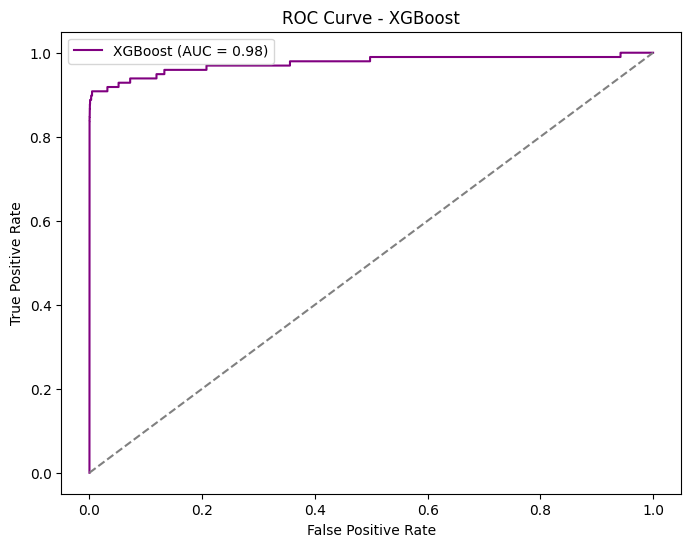

In [34]:
# Plotting ROC Curve for XG boost

# Probability
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC
plt.figure(figsize = (8,6))
plt.plot(fpr_xgb, tpr_xgb, color = "purple", label = f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot([0,1],[0,1], color = "gray", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

# **Step 6: Model Comparison**

In [42]:
# collecting all metrics

from sklearn.metrics import roc_auc_score

model_scores ={"Model":["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
               "Accuracy":[
                   accuracy_score(y_test, y_pred_log),
                   accuracy_score(y_test, y_pred_tree),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_xgb)
               ],
               "AUC Score":[
                   roc_auc_score(y_test,y_prob_log),
                   roc_auc_score(y_test,y_prob_dt),
                   roc_auc_score(y_test,y_prob_rf),
                   roc_auc_score(y_test,y_prob_xgb)
               ]
}

# Creating a Data Frame

results_df = pd.DataFrame(model_scores)
print(results_df)

                 Model  Accuracy  AUC Score
0  Logistic Regression  0.973368   0.970028
1        Decision Tree  0.966118   0.945984
2        Random Forest  0.999491   0.973669
3              XGBoost  0.999087   0.975279


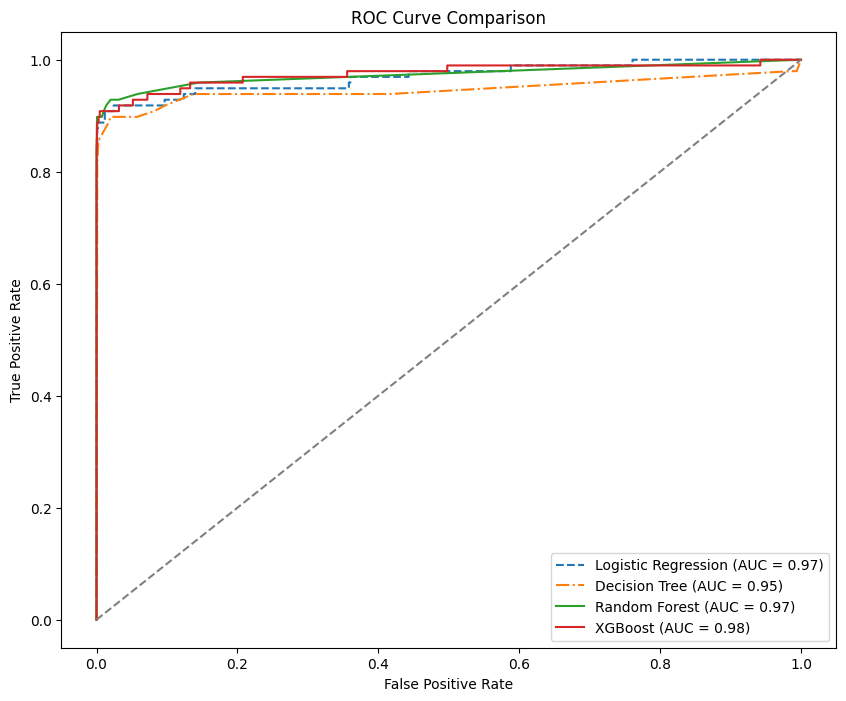

In [43]:
# Plotting ROC Curves for all model

plt.figure(figsize=(10,8))

# Logistic Regression
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})", linestyle="--")
# Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", linestyle="-.")
# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
# XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")

# Diagonal reference line
plt.plot([0,1], [0,1], color="gray", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# **Step 7: Feature Importance**

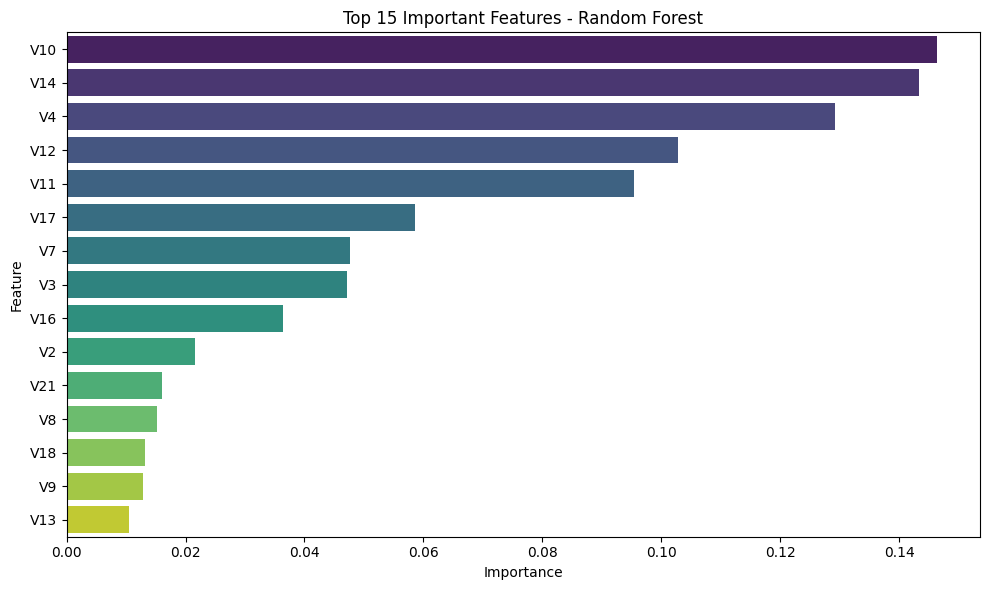

In [44]:
# Feature Importance for Random Forest

importances_rf = rf_model.feature_importances_
features = X.columns

# Create a DataFrame
feat_imp_rf = pd.DataFrame({"Feature": features, "Importance": importances_rf})
feat_imp_rf = feat_imp_rf.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_rf.head(15), palette="viridis")
plt.title("Top 15 Important Features - Random Forest")
plt.tight_layout()
plt.show()

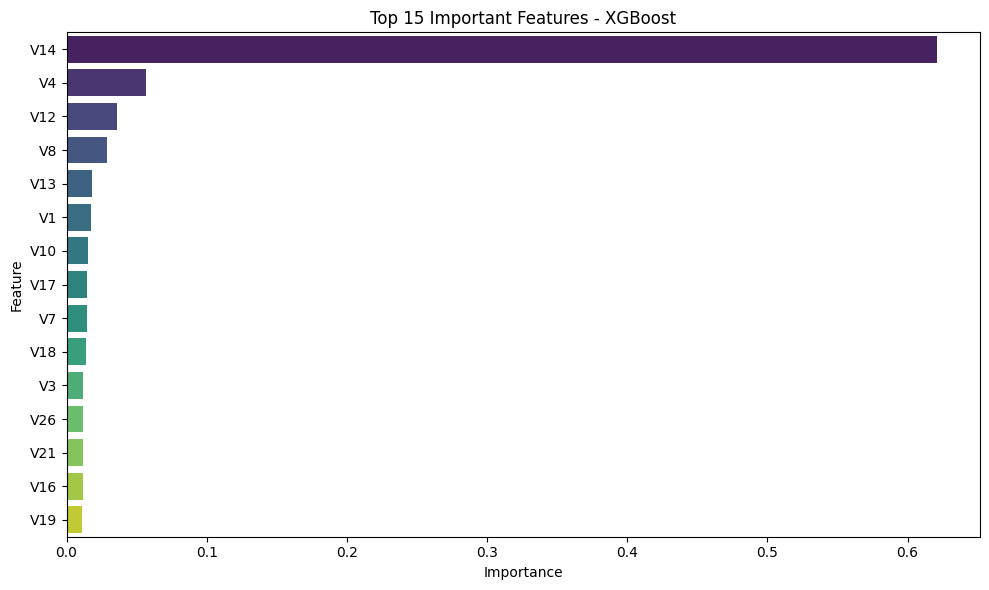

In [45]:
# Feature Importance for XGBoost

importance_xgb = xgb_model.feature_importances_
features = X.columns

# Creating a DataFrame
feat_imp_xgb = pd.DataFrame({"Feature": features, "Importance":importance_xgb})
feat_imp_xgb = feat_imp_xgb.sort_values(by = "Importance", ascending = False)

# Plotting
plt.figure(figsize = (10,6))
sns.barplot(x = "Importance", y = "Feature", data = feat_imp_xgb.head(15), palette = "viridis")
plt.title("Top 15 Important Features - XGBoost")
plt.tight_layout()
plt.show()

# **Step 8 : Saving the best Model**

In [47]:
import joblib

# Save Logistic Regression
joblib.dump(log_model, "logistic_regression_model.pkl")

# Save Random Forest
joblib.dump(rf_model, "random_forest_model.pkl")

# Save XGBoost
joblib.dump(xgb_model, "xgboost_model.pkl")

['xgboost_model.pkl']

# **Step 8 : Exporting Cleaned Data for Power BI**

In [48]:
# Add predictions to test data
results_df = X_test.copy()
results_df['Actual'] = y_test.values
results_df['Predicted_RF'] = y_pred_rf
results_df['Predicted_XGB'] = y_pred_xgb

# Save to CSV
results_df.to_csv("creditcard_predictions.csv", index=False)